KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001B81E5D4E50> (for post_execute):


KeyboardInterrupt: 

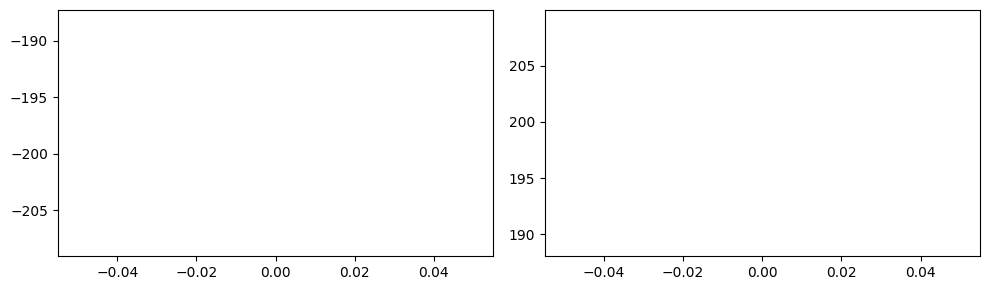

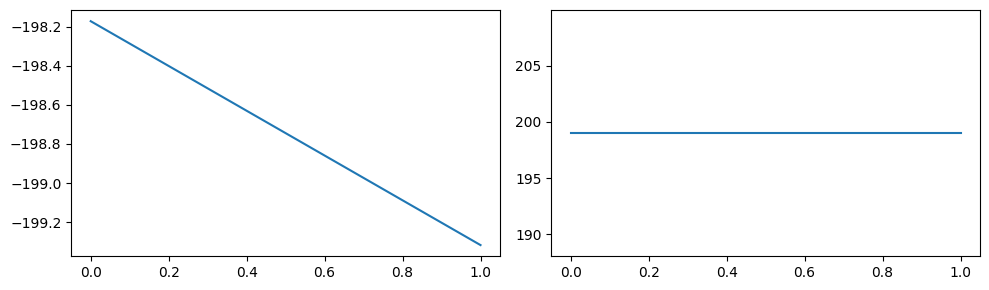

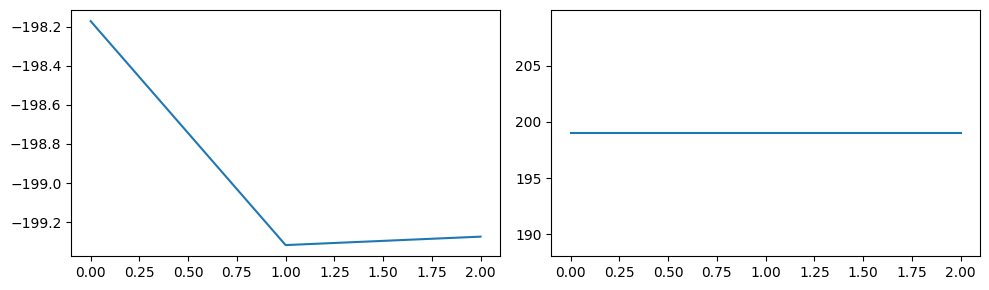

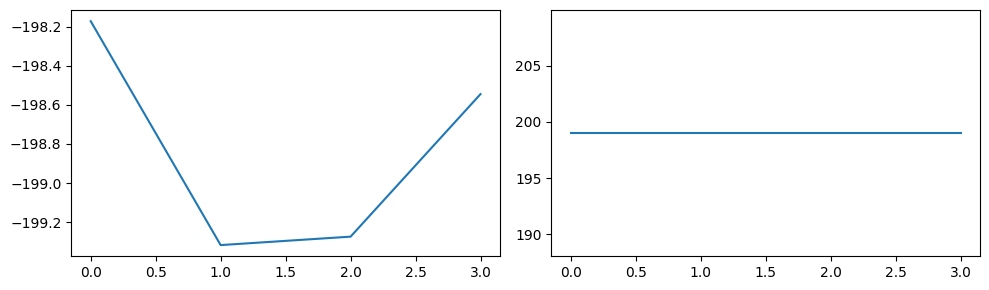

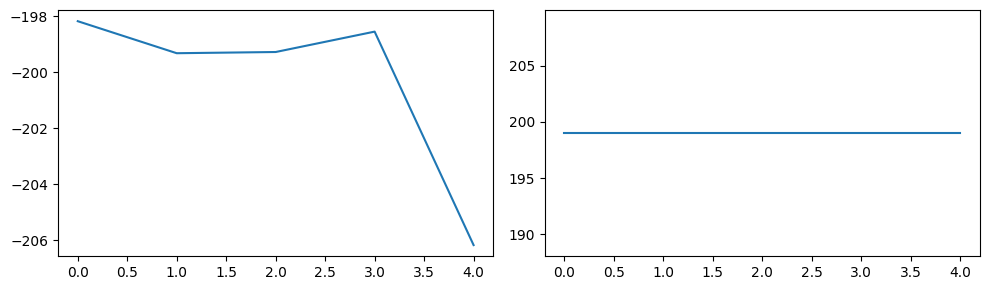

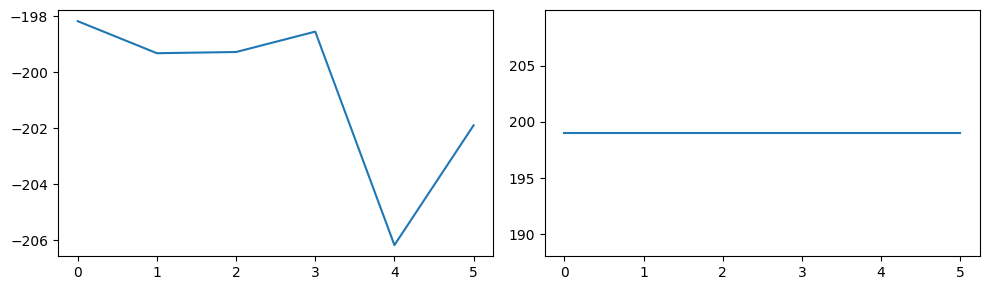

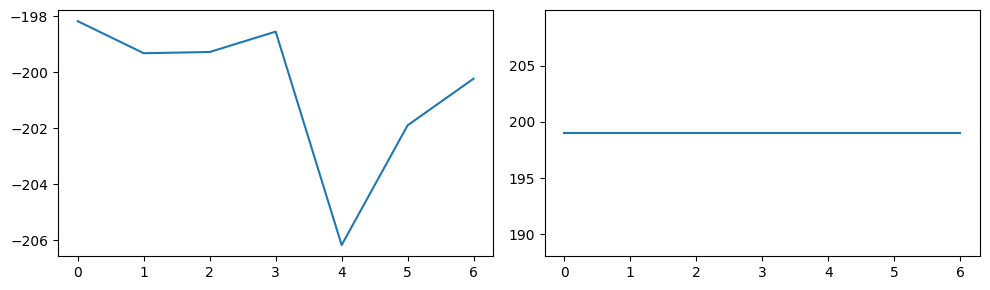

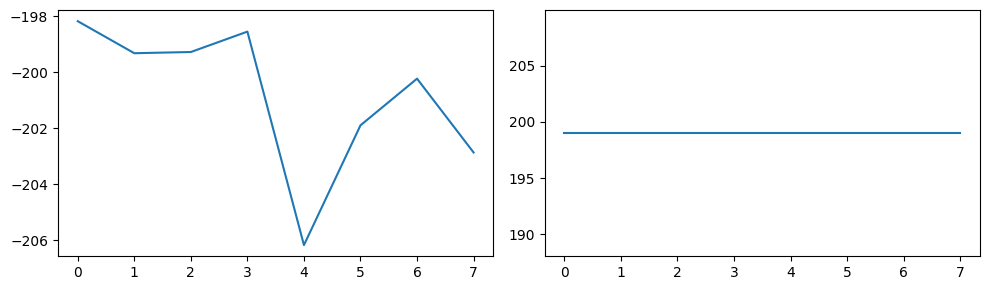

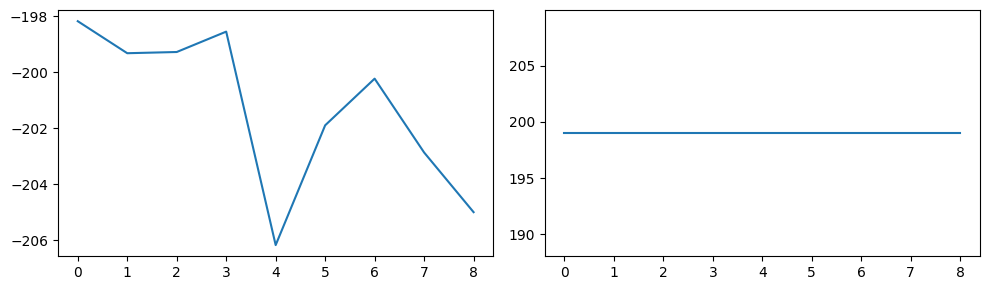

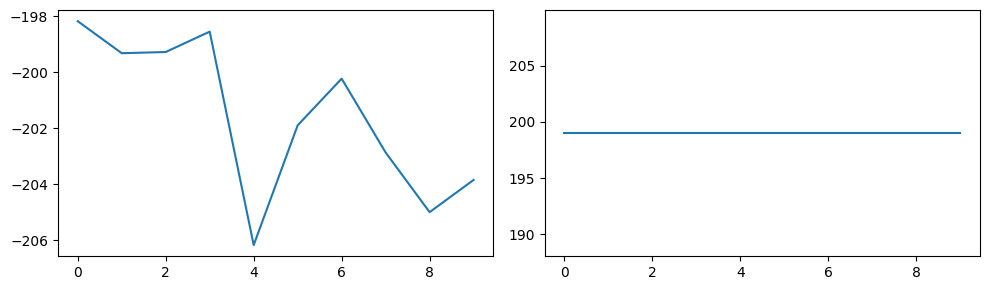

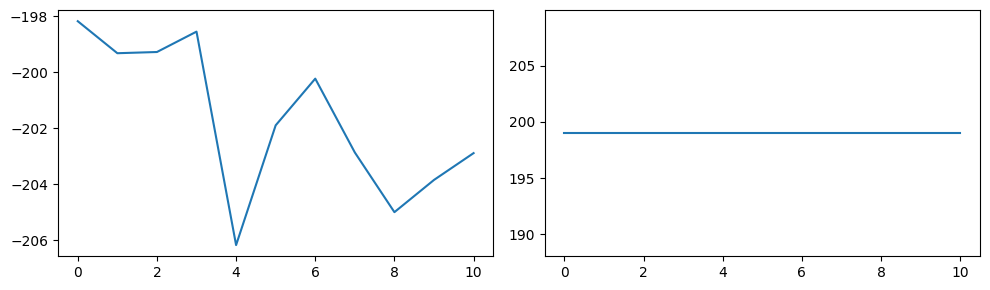

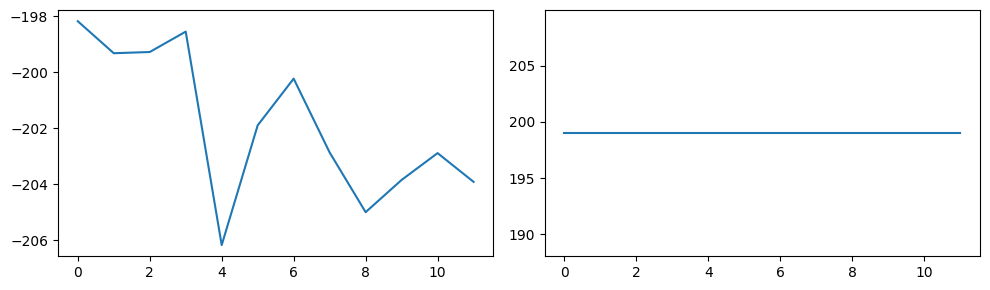

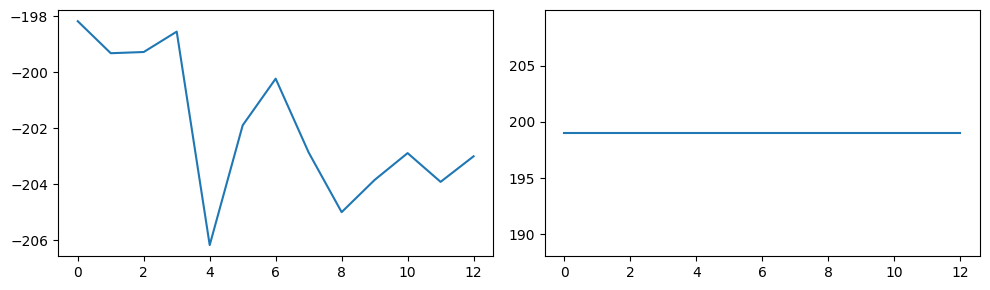

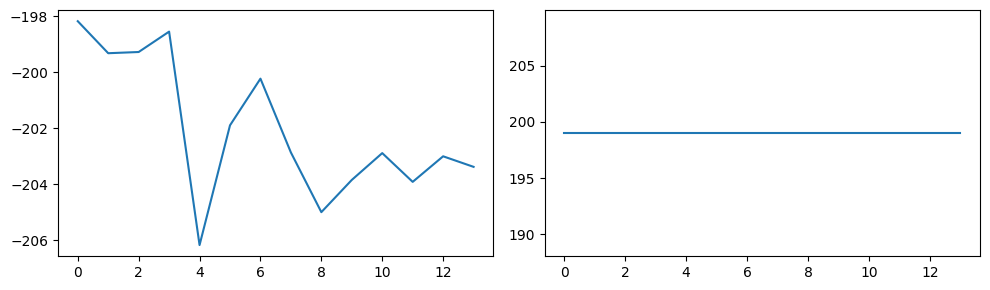

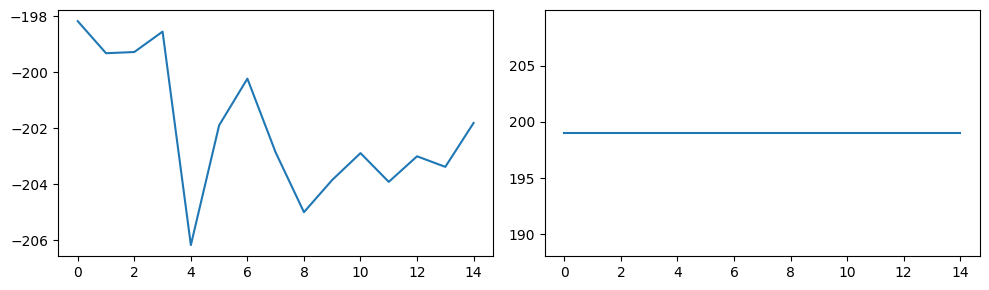

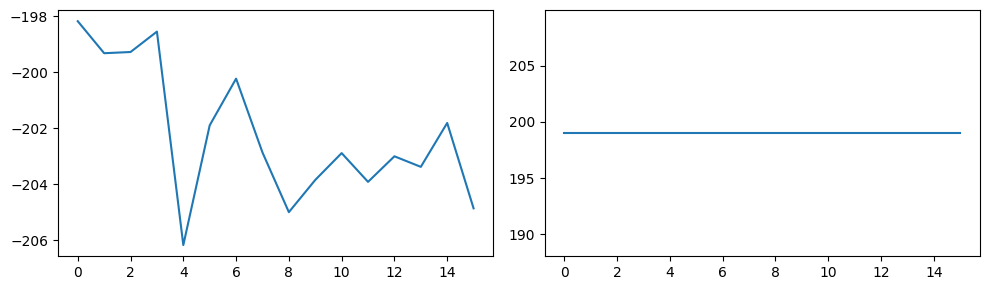

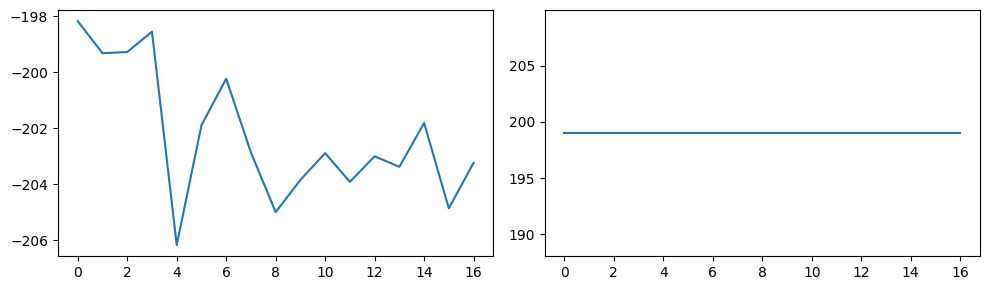

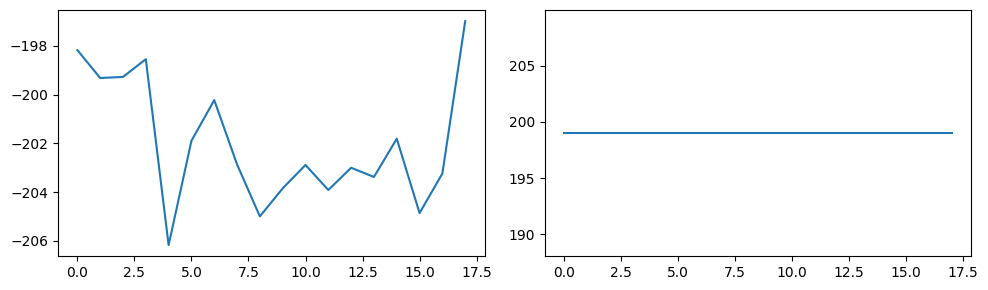

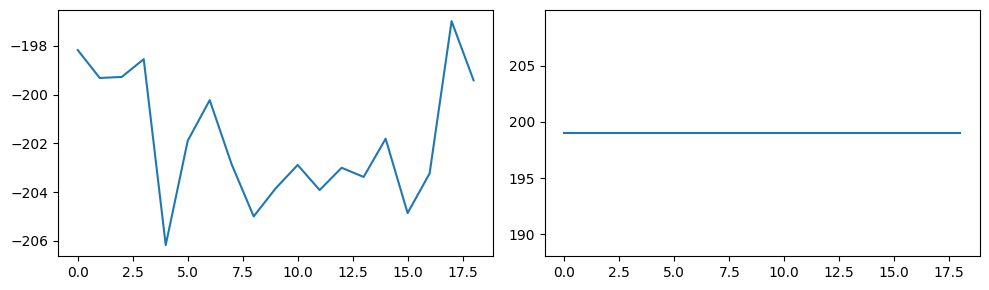

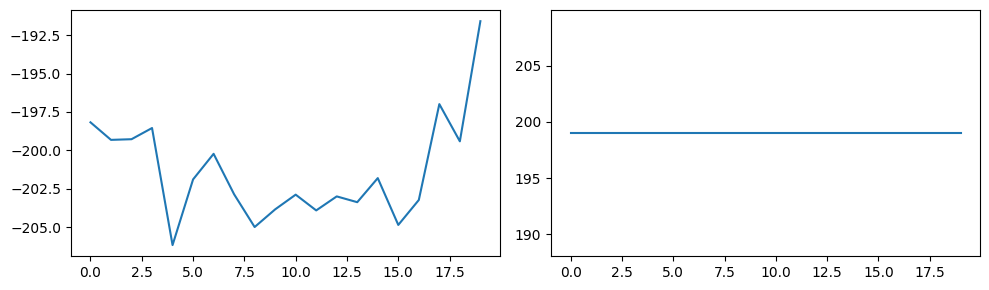

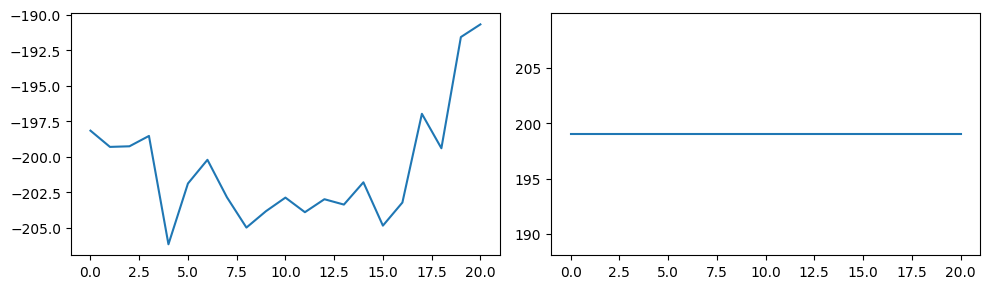

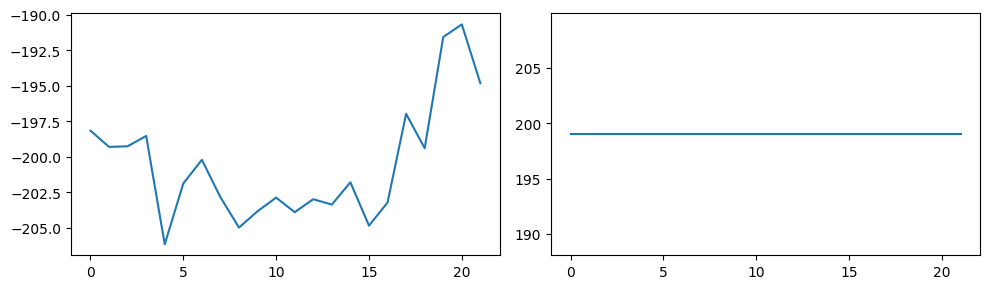

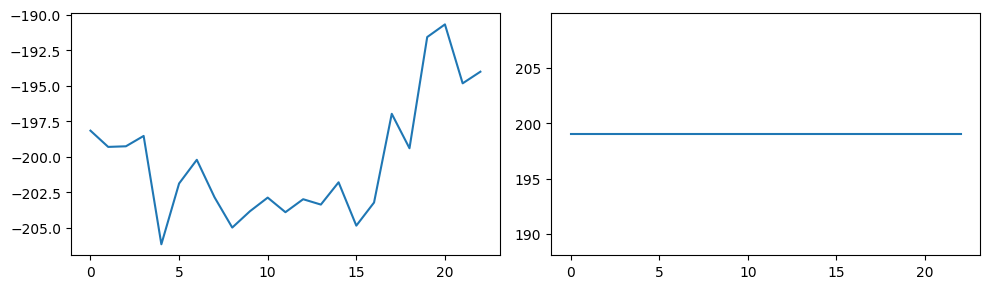

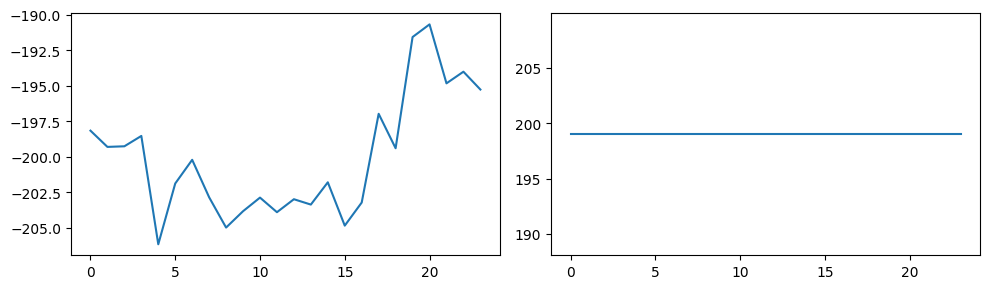

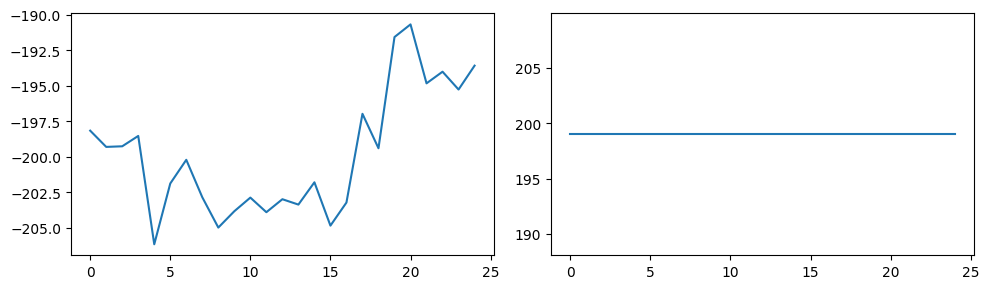

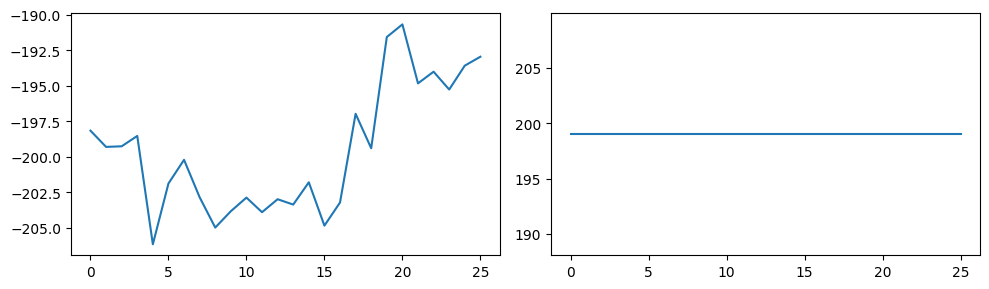

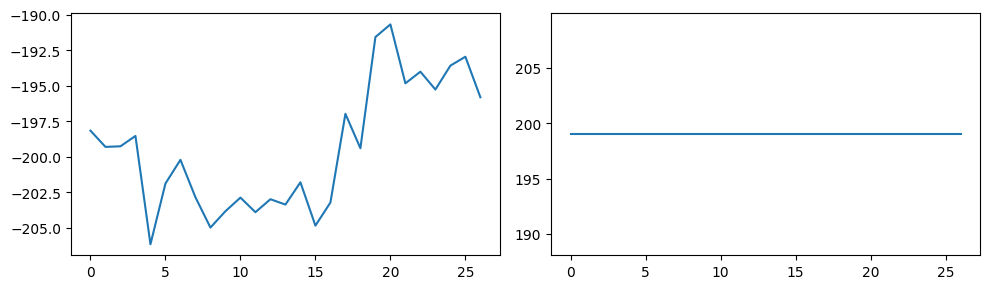

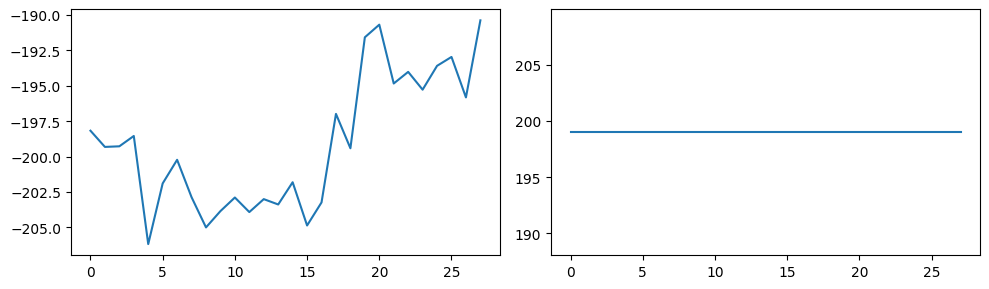

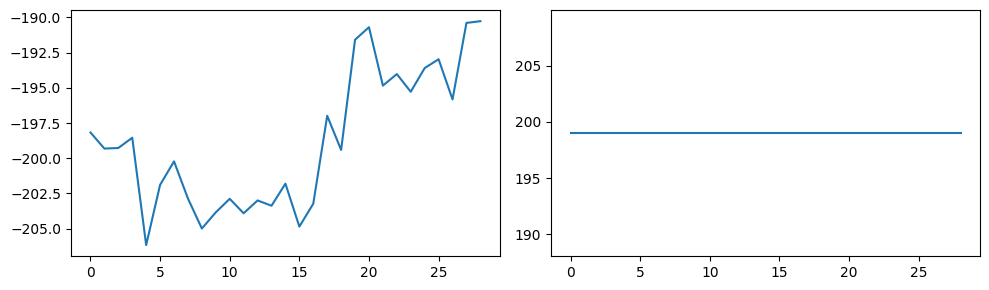

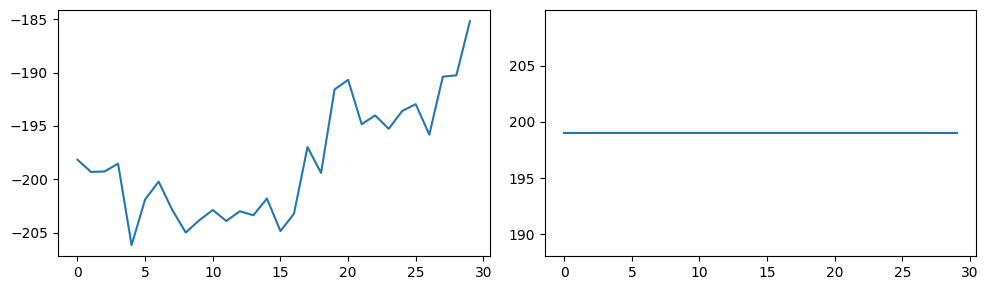

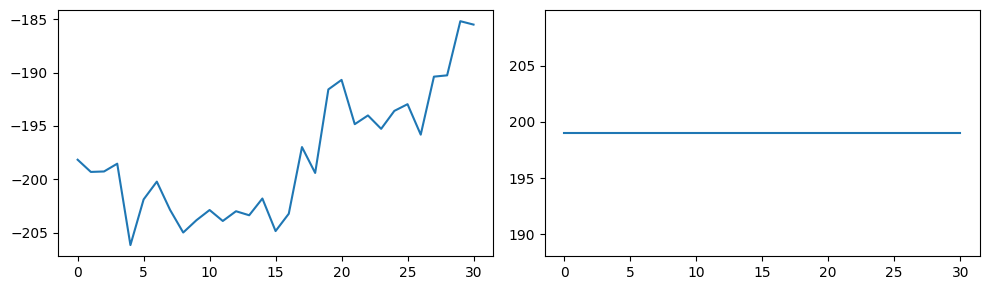

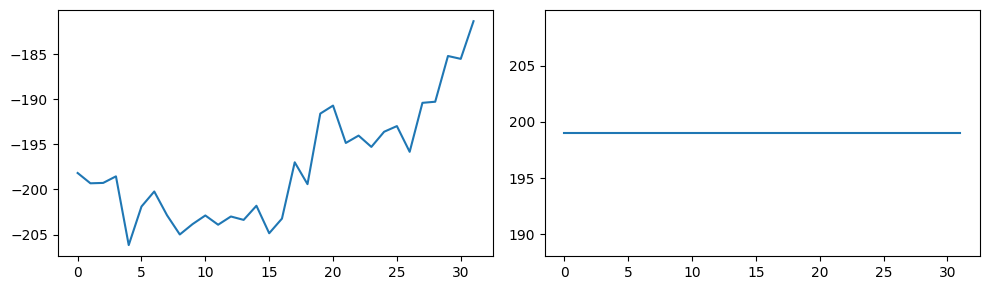

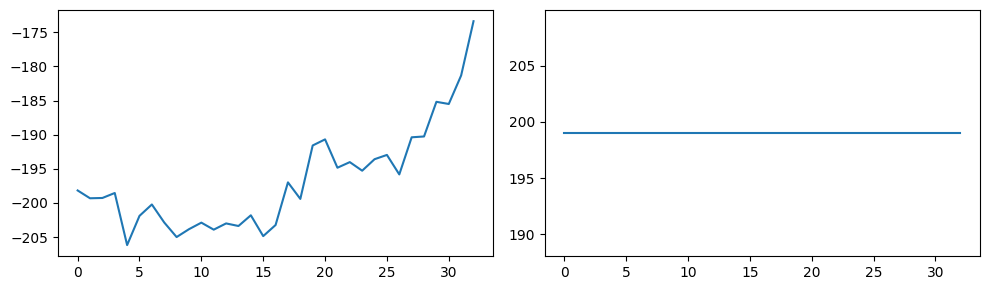

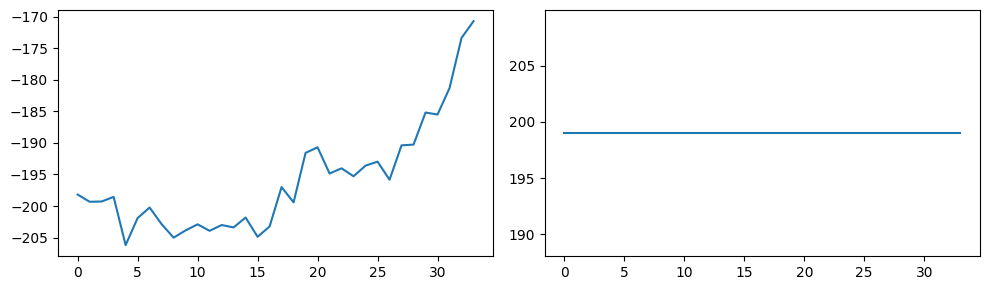

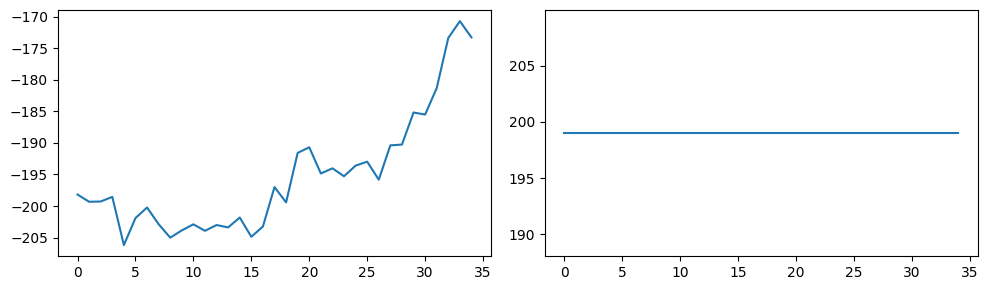

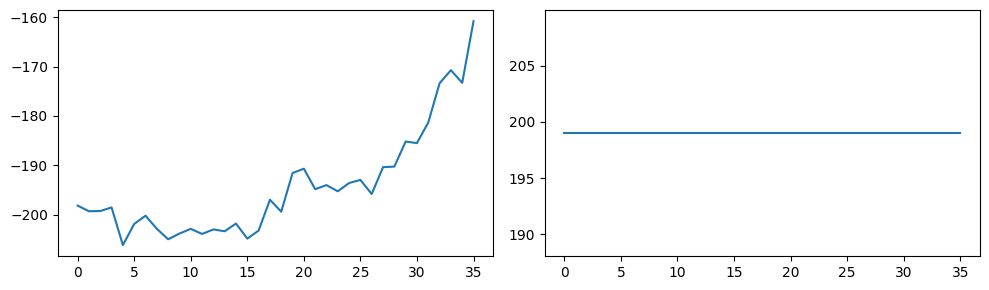

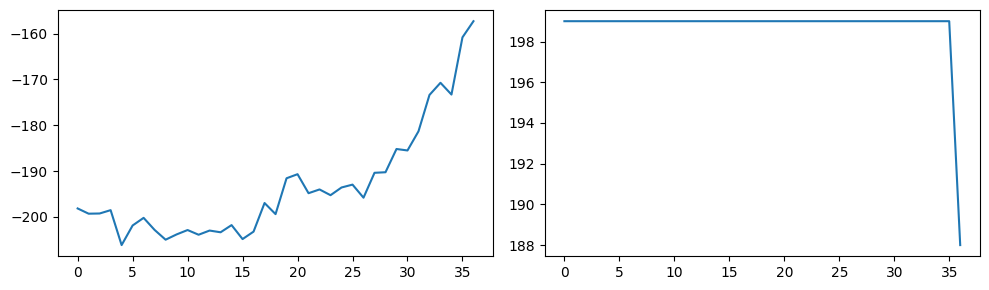

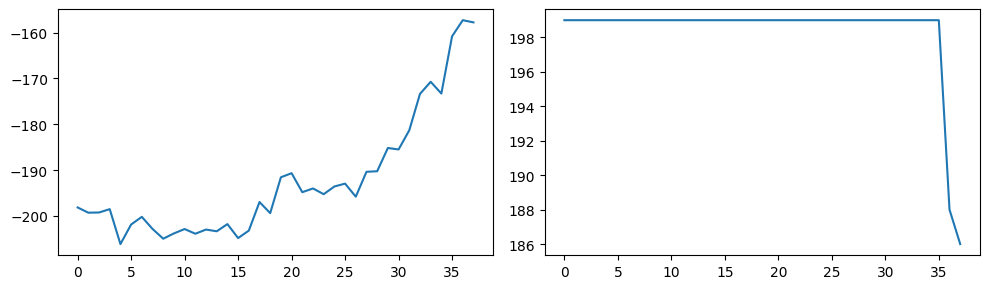

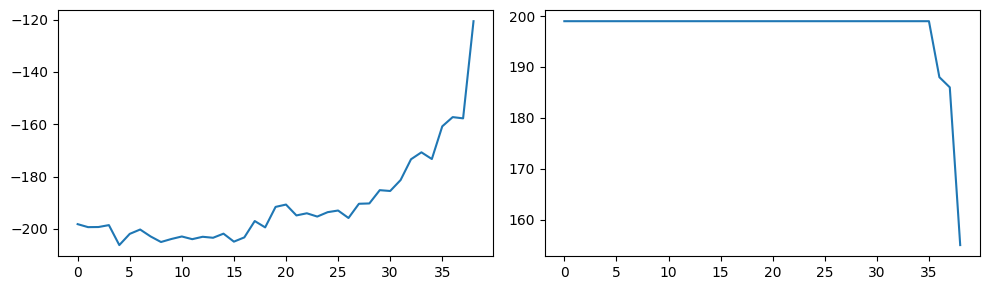

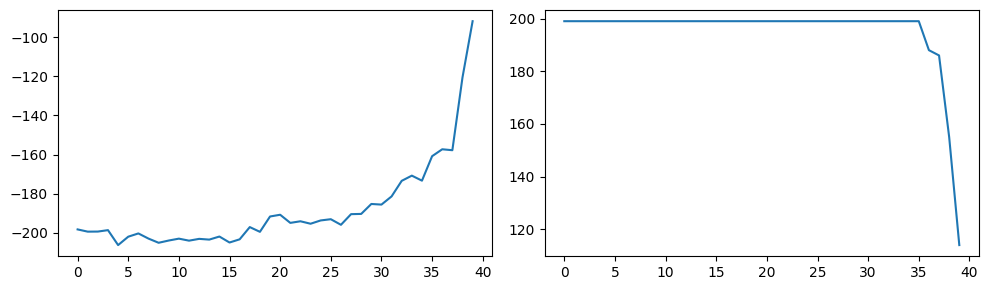

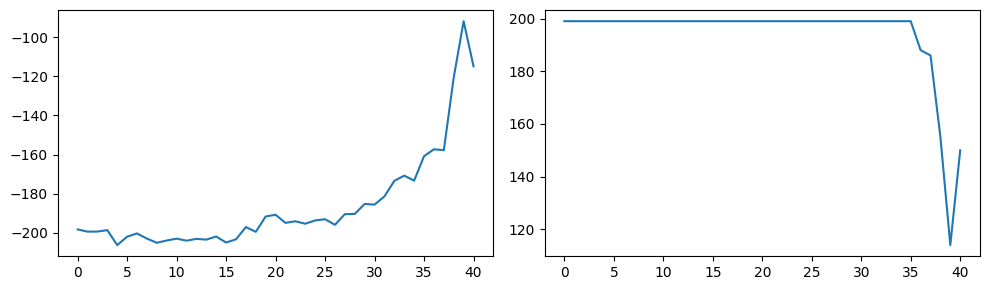

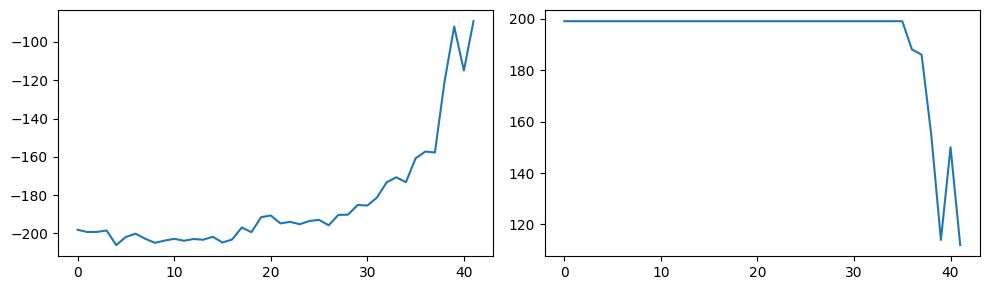

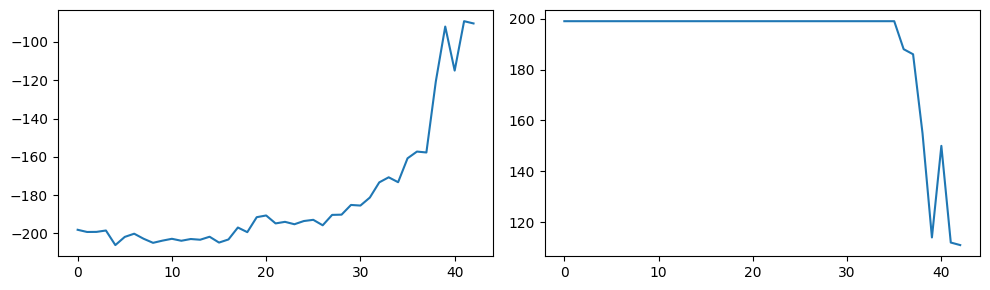

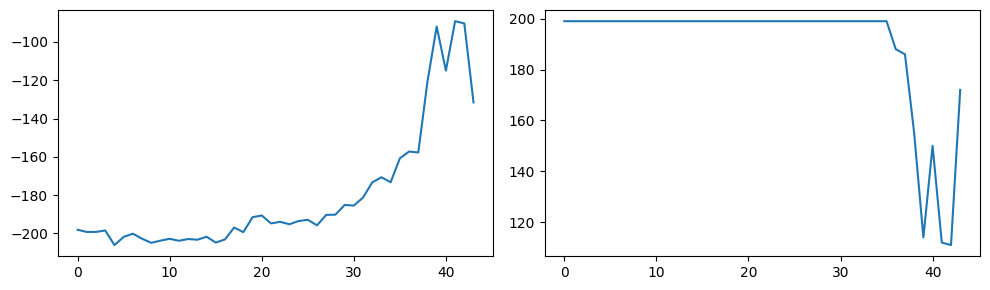

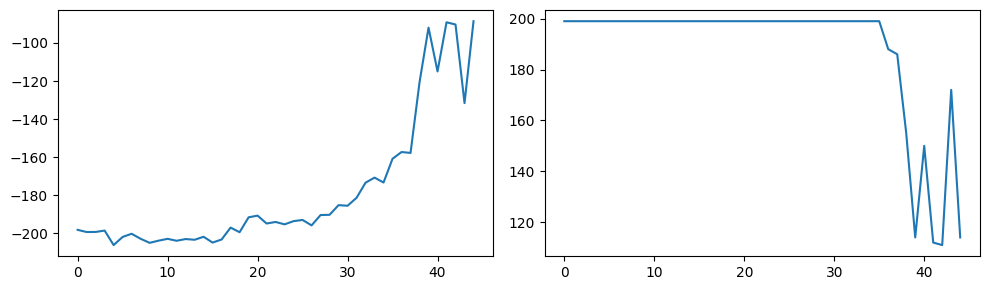

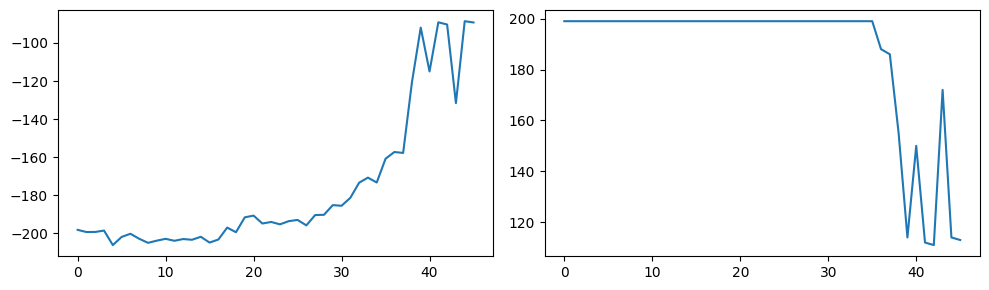

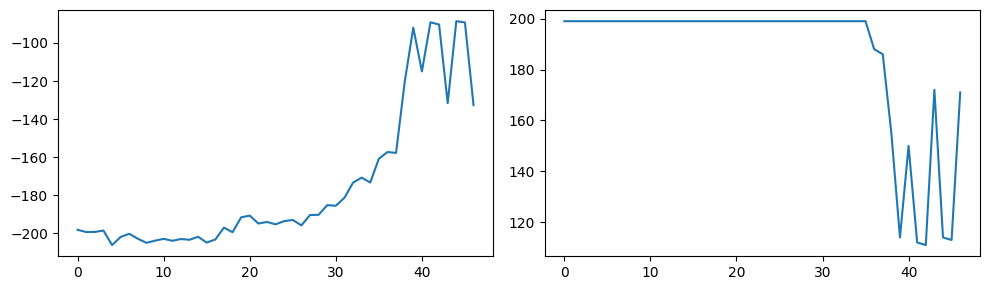

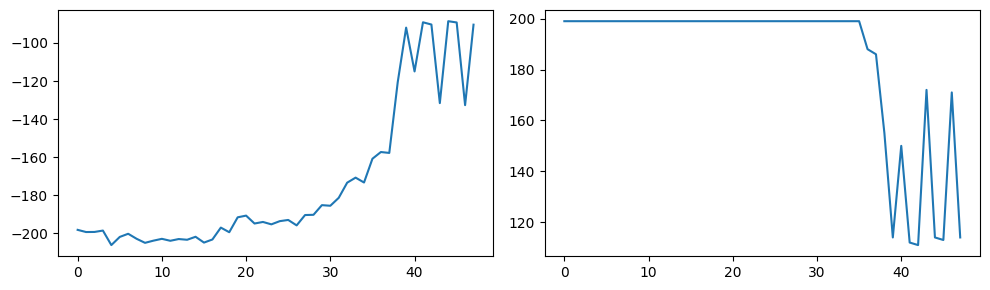

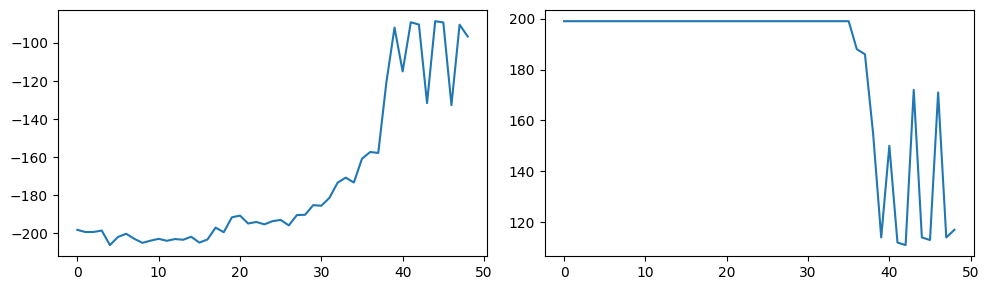

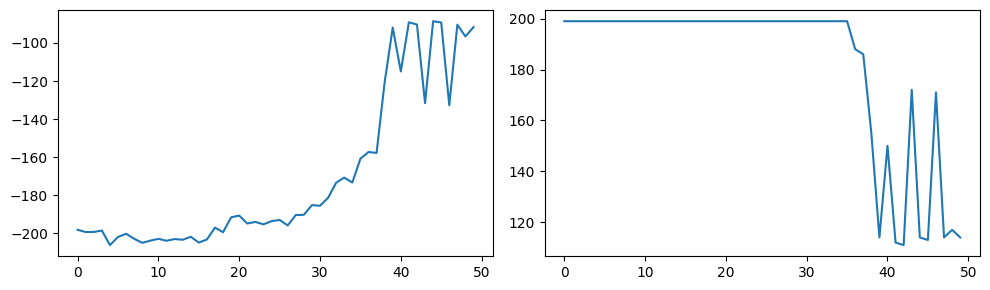

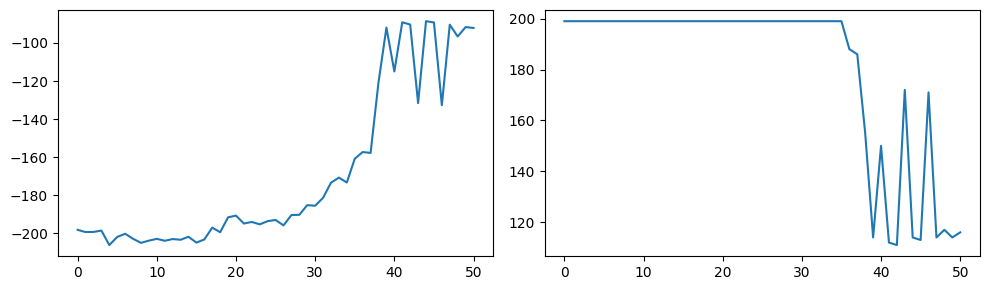

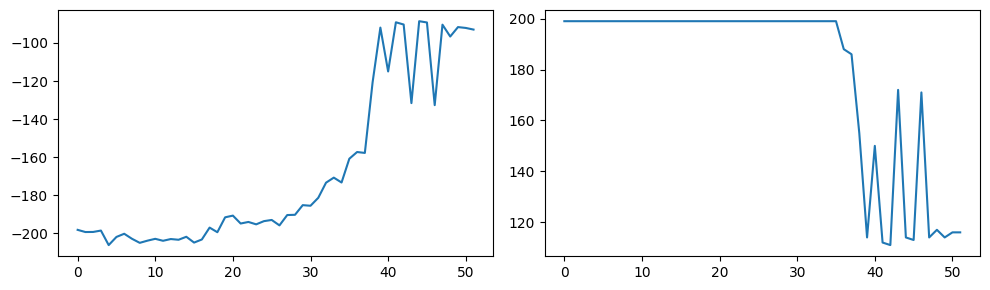

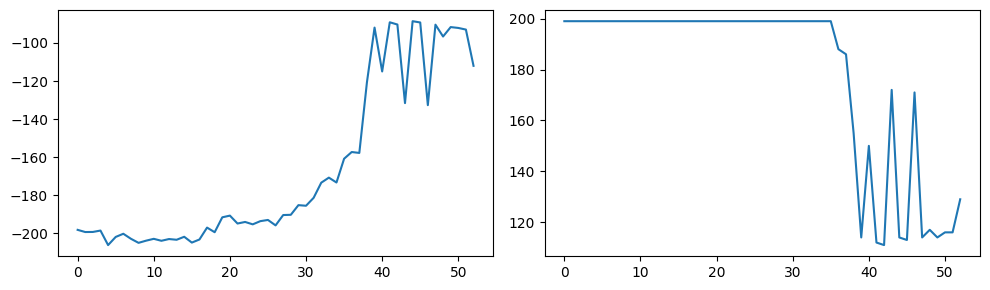

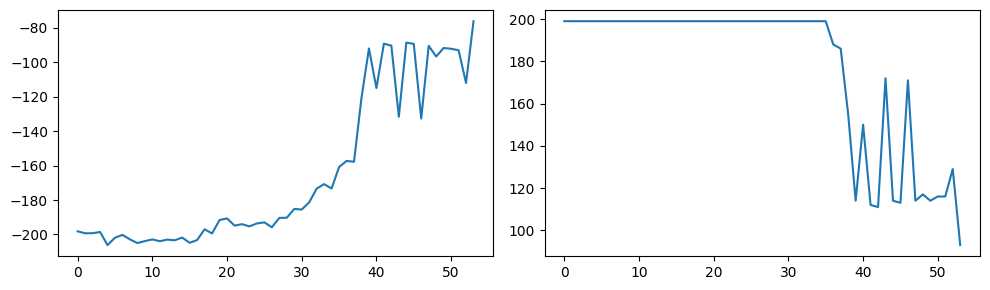

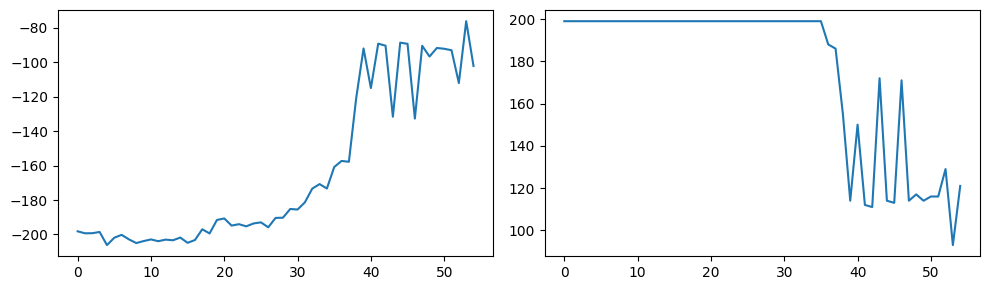

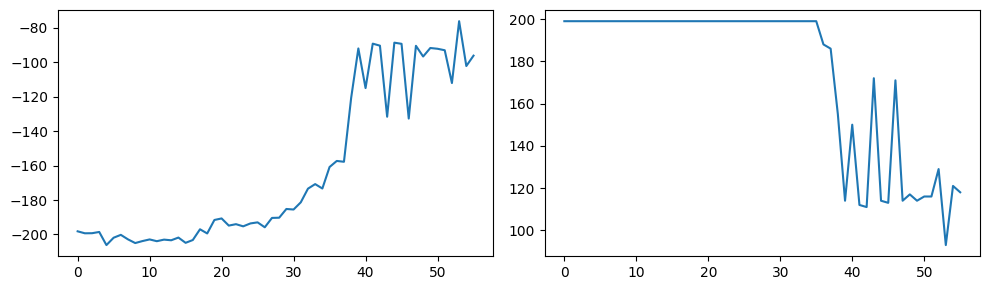

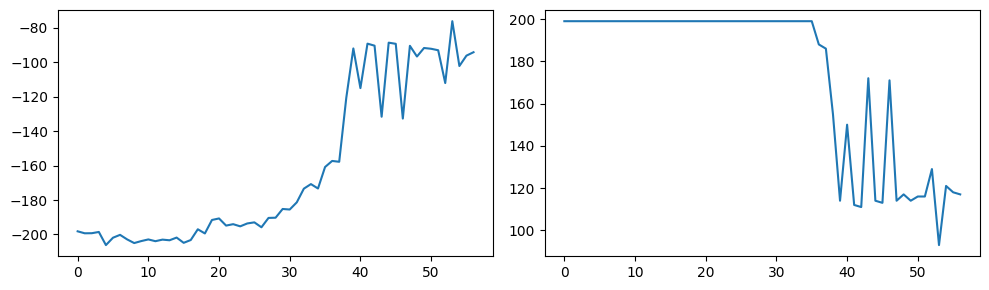

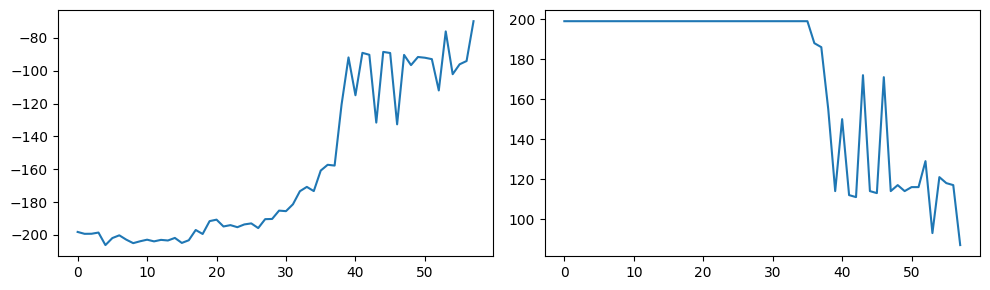

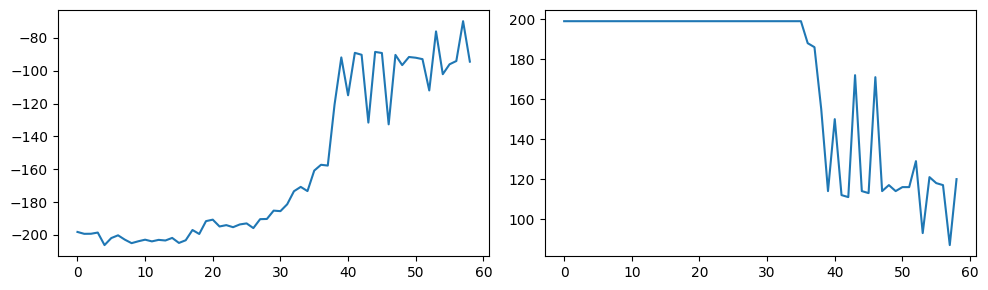

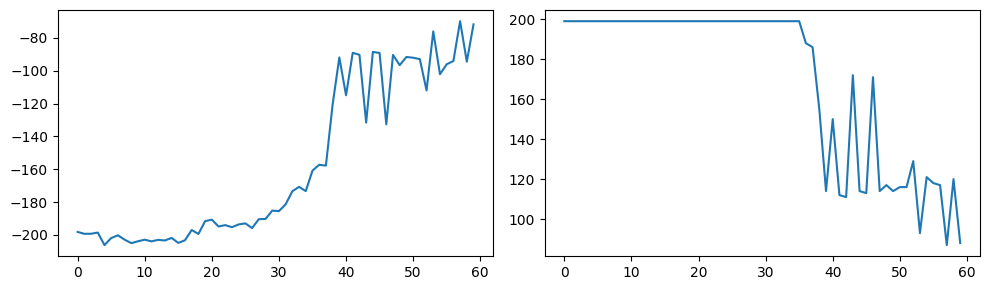

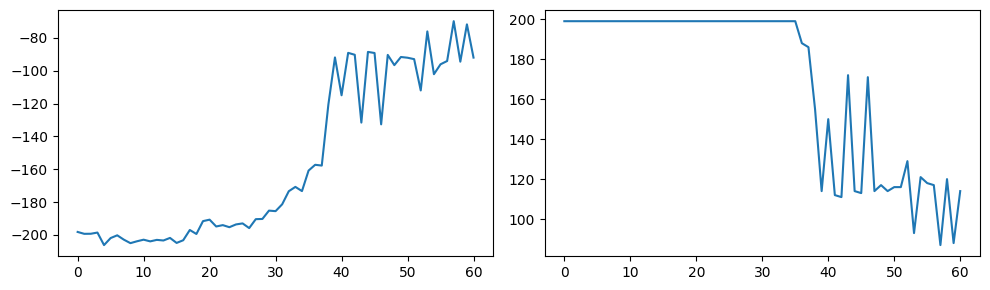

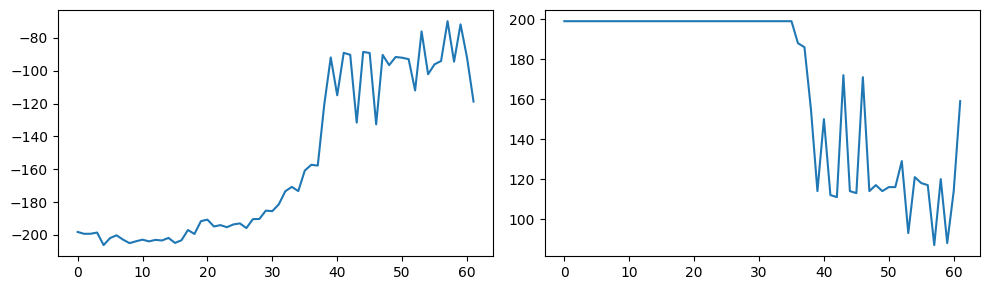

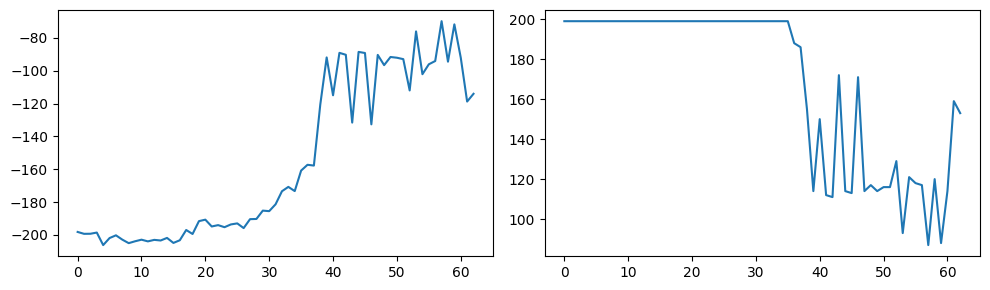

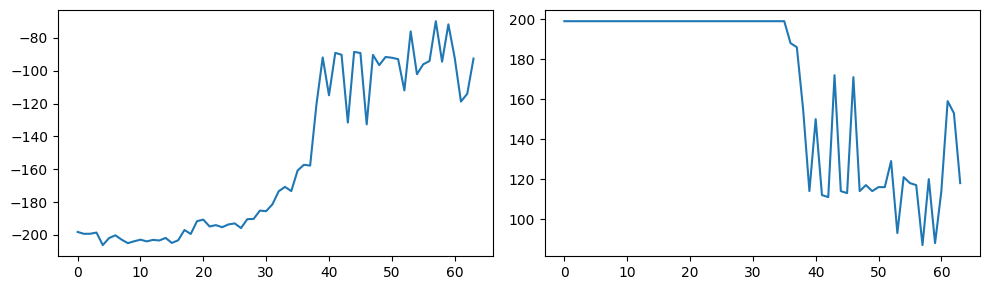

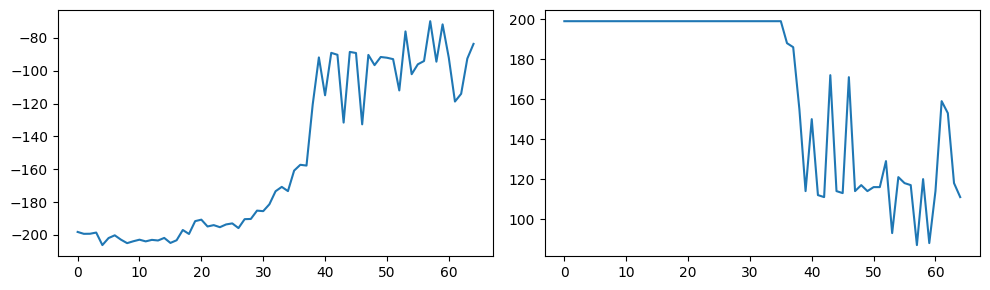

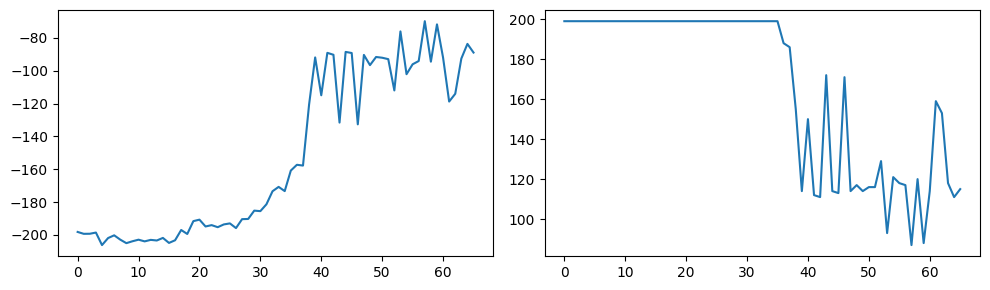

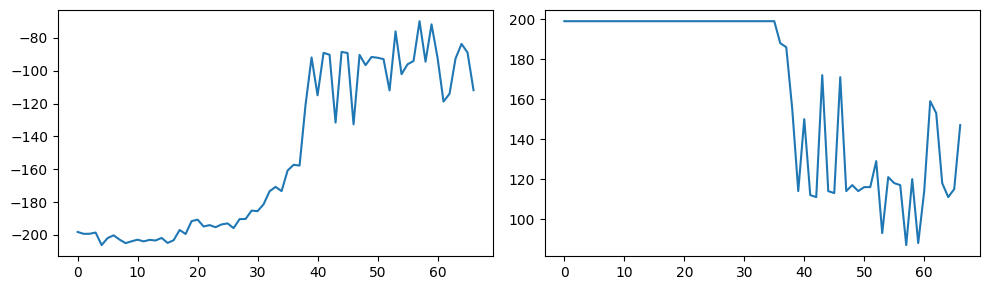

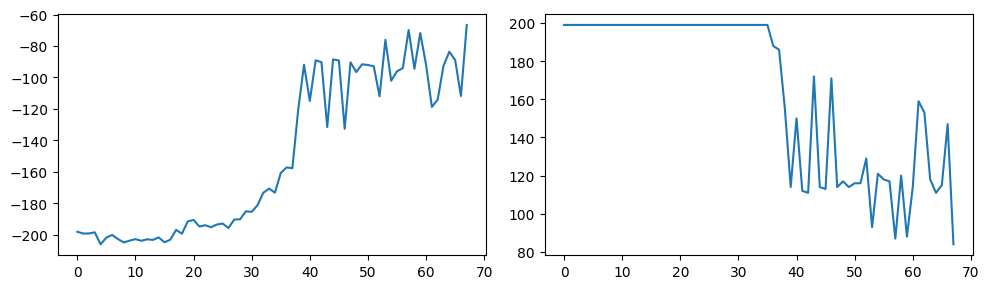

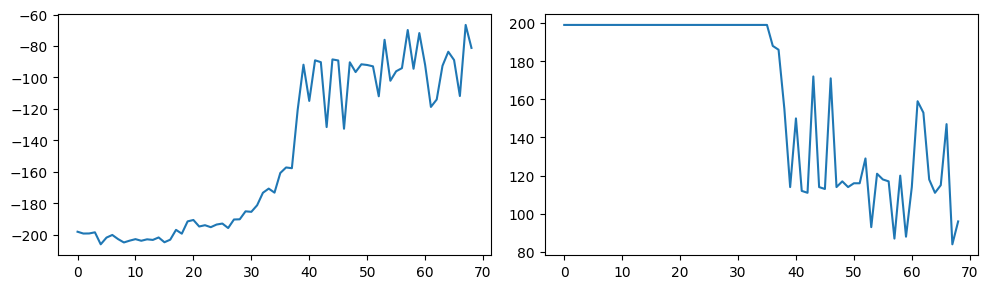

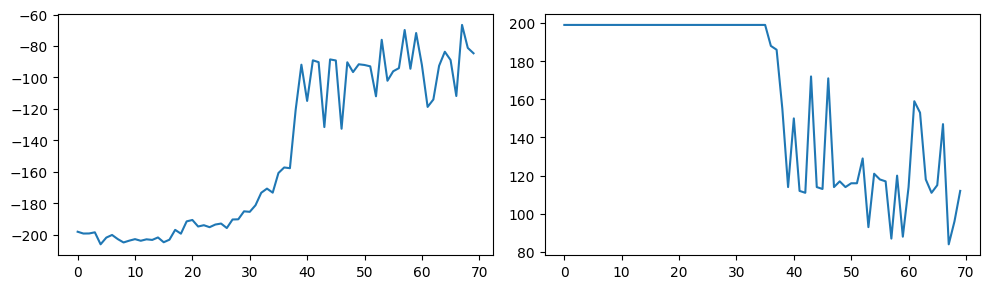

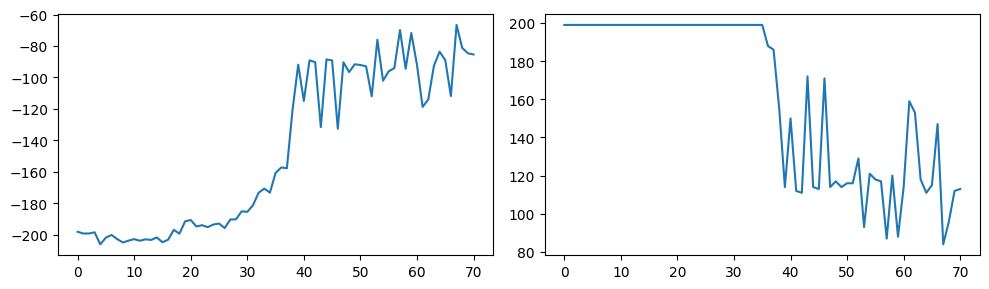

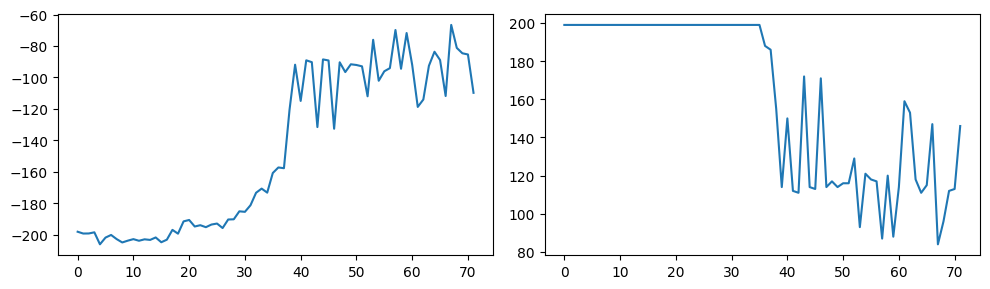

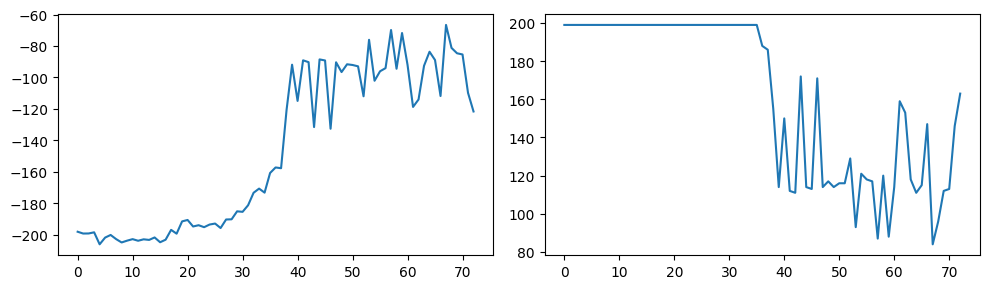

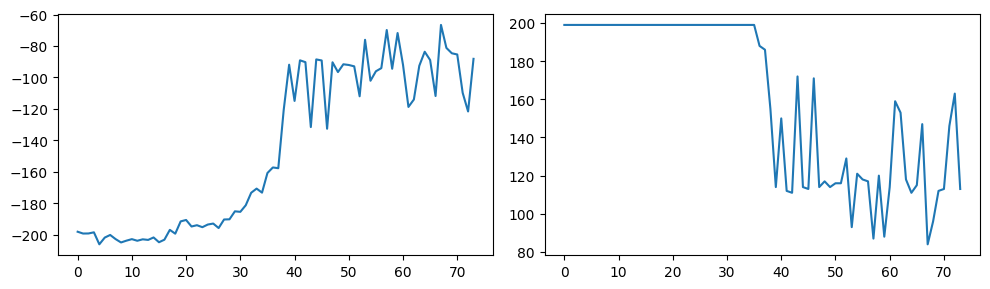

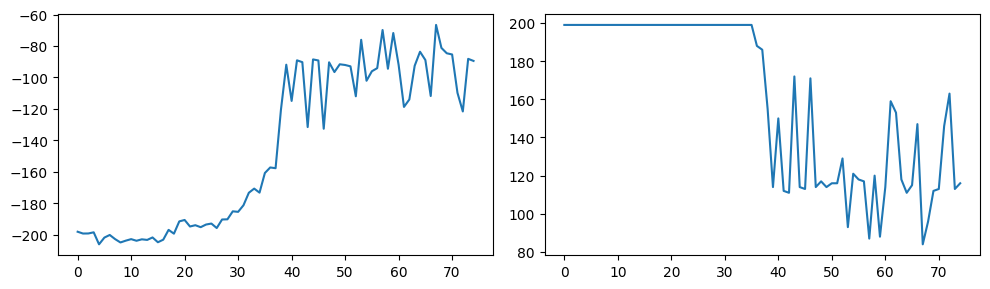

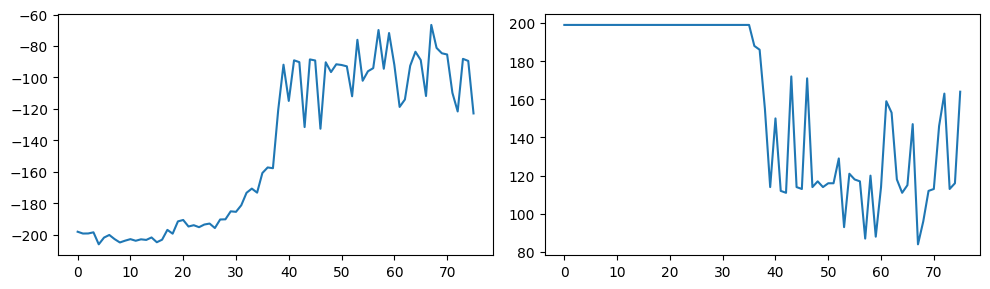

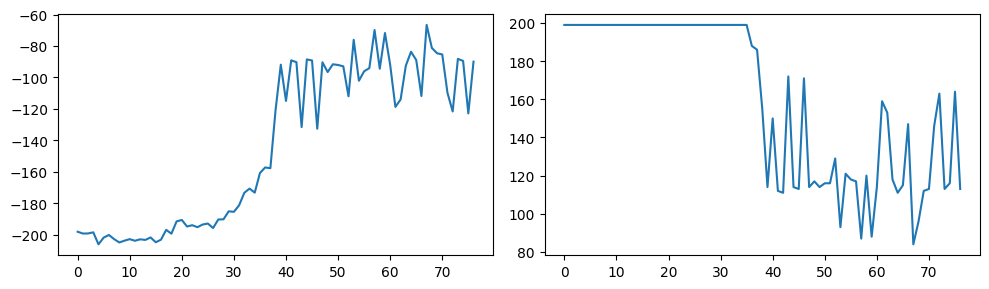

<Figure size 640x480 with 0 Axes>

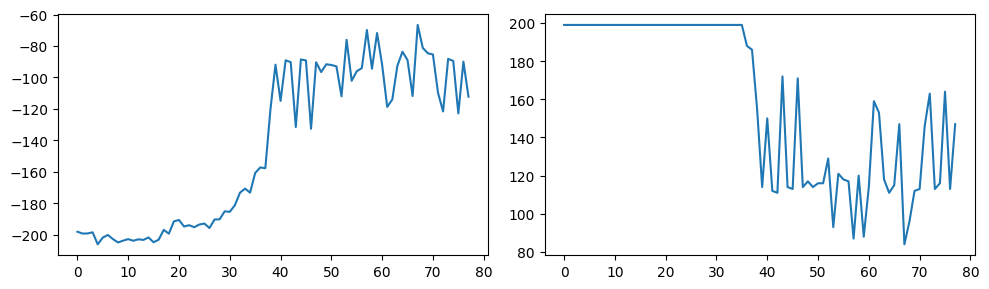

In [21]:
#training only notebook for mountain-car task
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
env = gym.make("MountainCar-v0", render_mode="human")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state action next_state reward'))

class ReplayMemory:
    def __init__(self,capacity):
        self.memory = deque([], maxlen = capacity)
    def push(self,*args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Sequential):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__(
        nn.Linear(n_observations, 64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64, n_actions))

BATCH_SIZE=128
GAMMA=0.99
EPS_START=0.9
EPS_END=0.05
EPS_DECAY=500
TAU=0.0005
LR=1e-3

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations,n_actions).to(device)
target_net = DQN(n_observations,n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory=ReplayMemory(5000)

steps_done = 0
def plot_rewards(rewards, timings):
    
    plt.figure(1)
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    axes[0].plot(rewards)
    axes[1].plot(timings)
    fig.tight_layout()
    display.display(plt.gcf())
    display.clear_output(wait=True)
def select_action(state):
    global steps_done
    EPS = EPS_END +(EPS_START-EPS_END)*math.exp(-1*steps_done/EPS_DECAY)
    sample = random.random()
    steps_done +=1
    if sample > EPS:
        with torch.no_grad():
            return policy_net.forward(state).max(1)[1].view(1,1)
    else: 
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optim_model():
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
    next_state_batch = torch.cat([ s for s in batch.next_state if s is not None])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action = policy_net.forward(state_batch).gather(1,action_batch)
    next_state_action = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_action[non_final_mask] = target_net.forward(next_state_batch).max(1)[0]
    expected = GAMMA*next_state_action+(reward_batch+1)
    lss = nn.SmoothL1Loss()
    loss =lss(state_action,expected.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
if torch.cuda.is_available():
    num_episodes=600
else:
    num_episodes = 50
rewards_array = []
timings_array = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
    rewards=0
    for n in count():
        action = select_action(state)
        observe,reward,terminated,truncated,_ = env.step(action.item())
        done = terminated or truncated
        #reward = reward + (abs(state[0,0].item()+0.5)**2)*0.05+abs(state[0,1].item())*10 # + rewards*5e-4
        reward = reward + abs(state[0,1].item())*10  + rewards*5e-4 # reward is based on velocity and sum 
        #of previous rewards, shows good (but not excellent) result.(car reaches goal for at least 300 iterations)
        #but timings are not the best
        #basic reward from environment can not be used because base reward is -1 util task is solved randomly
        #but waiting for random solution will be too long, so we should modify reward
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observe, device=device, dtype=torch.float32).unsqueeze(0)
        rewards +=reward
        memory.push(state,action,next_state,torch.tensor([reward], device=device, dtype = torch.float32))
        state = next_state
        if i_episode < 500:
            optim_model()
        tnd = target_net.state_dict()
        pnd = policy_net.state_dict()
        for key in tnd:
            tnd[key] = TAU*pnd[key]+tnd[key]*(1-TAU)
        target_net.load_state_dict(tnd)    
        if done:
            rewards_array.append(rewards)
            timings_array.append(n)
            plot_rewards(rewards_array, timings_array)
            break